In [3]:
import os
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import sigma
from pycbc.types import FrequencySeries
from pycbc import noise, distributions
from gwpy.timeseries import TimeSeries
from tqdm import tqdm
from astropy import units as u

# === Parameters ===
fs = 4096
duration = 4.0
delta_t = 1.0 / fs
tsamples = int(fs * duration)
flow = 30.0
target_snr_range = (8, 12)
mass_dist = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))
injection_times = [1.0, 1.5, 2.0, 2.5, 3.0]

# === Directories ===
base_dir = "./combined-dataset/"
dirs = {
    "real_noise": os.path.join(base_dir, "real-noise"),
    "real_signal_injected": os.path.join(base_dir, "real-signal-injected"),
    "real_signal": os.path.join("real-signal"),
    "synthetic_noise": os.path.join(base_dir, "synthetic-noise"),
    "synthetic_signal_injected": os.path.join(base_dir, "synthetic-signal-injected"),
    "synthetic_signal": os.path.join("synthetic-signal")
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# === Load Real Noise ===
real_noise_dir = "./dataset/real-noise-files/"
real_files = sorted([f for f in os.listdir(real_noise_dir) if f.endswith(".txt")])

# === PSD Template ===
delta_f = 1.0 / duration
flen = int(2048 / delta_f) + 1
psd_template = aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_template[psd_template == 0] = 1e-40
psd_template = FrequencySeries(psd_template, delta_f=delta_f)

# === Real Noise Injection ===
for idx, file in tqdm(enumerate(real_files), total=len(real_files), desc="Real Noise Processing"):
    try:
        noise_path = os.path.join(real_noise_dir, file)
        noise_ts = TimeSeries.read(noise_path)
        noise_ts = noise_ts.taper('leftright', 0.5).bandpass(35, 350).crop(noise_ts.t0.value, noise_ts.t0.value + duration)
        noise_pycbc = noise_ts.to_pycbc()

        m1, m2 = mass_dist.rvs(size=1)[0]
        if m1 < m2:
            m1, m2 = m2, m1
        hp, _ = get_td_waveform(approximant="SEOBNRv2", mass1=m1, mass2=m2, delta_t=delta_t, f_lower=40.0,
                                 distance=1, inclination=np.random.uniform(0, np.pi),
                                 spin1z=np.random.uniform(-0.99, 0.99),
                                 spin2z=np.random.uniform(-0.99, 0.99))

        ht = hp.to_frequencyseries()
        psd = aLIGOZeroDetHighPower(len(ht), ht.delta_f, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=ht.delta_f)

        snr = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr) or snr == 0:
            continue

        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr

        signal_ts = TimeSeries.from_pycbc(hp)
        signal_ts.t0 = noise_ts.t0 + np.random.choice(injection_times) * u.second
        injected_ts = noise_ts.inject(signal_ts)

        noise_ts.write(os.path.join(dirs["real_noise"], f"real_noise_{idx}.txt"))
        signal_ts.write(os.path.join(dirs["real_signal"], f"real_signal_{idx}.txt"))
        injected_ts.write(os.path.join(dirs["real_signal_injected"], f"real_injected_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Real [{idx}] skipped: {e}")

# === Synthetic Noise Injection ===
for idx in tqdm(range(len(real_files)), desc="Synthetic Noise Generation"):
    try:
        noise_data = noise.noise_from_psd(tsamples, delta_t, psd_template)
        noise_ts = TimeSeries.from_pycbc(noise_data)
        noise_ts = noise_ts.taper('leftright', 0.5).bandpass(35, 350)

        m1, m2 = mass_dist.rvs(size=1)[0]
        if m1 < m2:
            m1, m2 = m2, m1
        hp, _ = get_td_waveform(approximant="SEOBNRv2", mass1=m1, mass2=m2, delta_t=delta_t, f_lower=40.0,
                                 distance=1, inclination=np.random.uniform(0, np.pi),
                                 spin1z=np.random.uniform(-0.99, 0.99),
                                 spin2z=np.random.uniform(-0.99, 0.99))

        ht = hp.to_frequencyseries()
        psd = aLIGOZeroDetHighPower(len(ht), ht.delta_f, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=ht.delta_f)

        snr = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr) or snr == 0:
            continue

        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr

        signal_ts = TimeSeries.from_pycbc(hp)
        signal_ts.t0 = np.random.choice(injection_times)
        injected_ts = noise_ts.inject(signal_ts)

        noise_ts.write(os.path.join(dirs["synthetic_noise"], f"synthetic_noise_{idx}.txt"))
        signal_ts.write(os.path.join(dirs["synthetic_signal"], f"synthetic_signal_{idx}.txt"))
        injected_ts.write(os.path.join(dirs["synthetic_signal_injected"], f"synthetic_injected_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Synthetic [{idx}] skipped: {e}")


Synthetic Noise Generation: 100%|██████████| 4480/4480 [42:41<00:00,  1.75it/s]


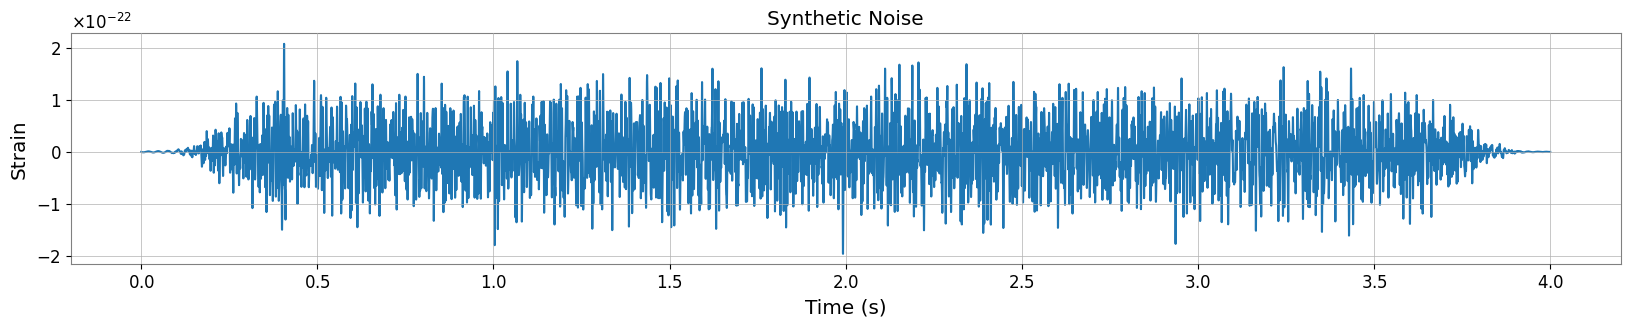

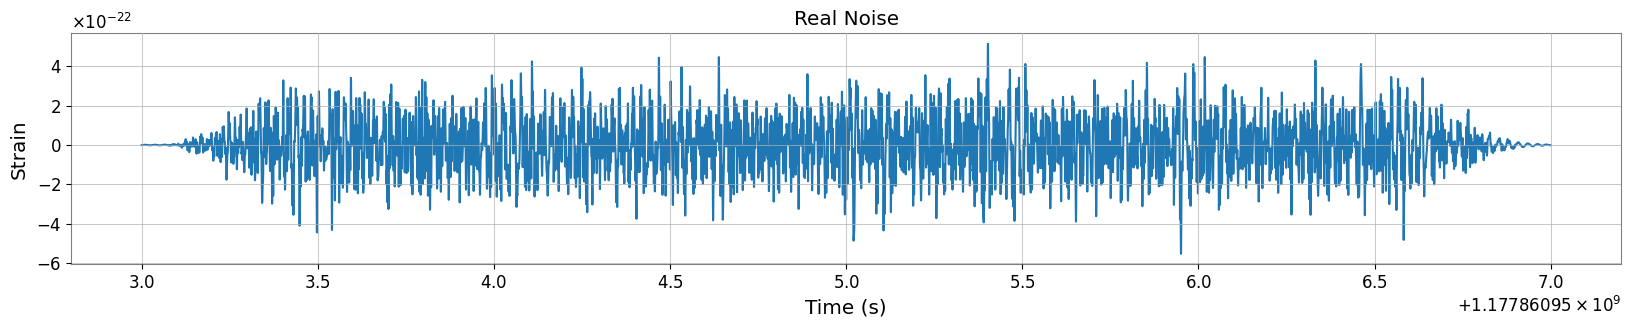

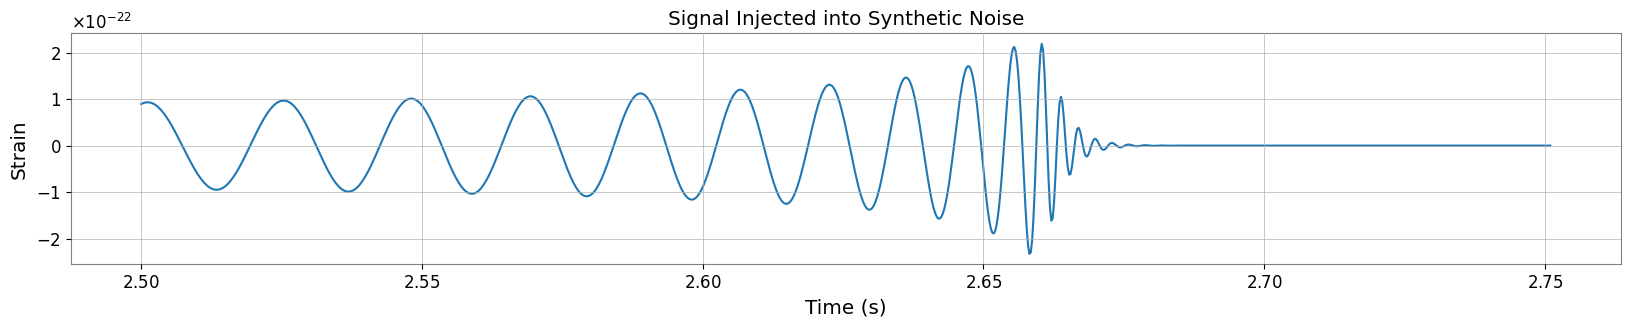

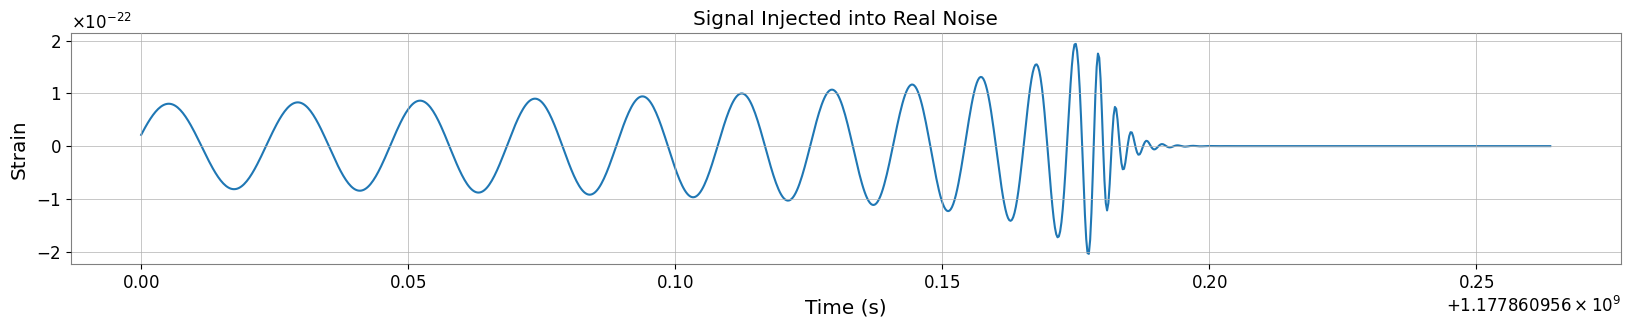

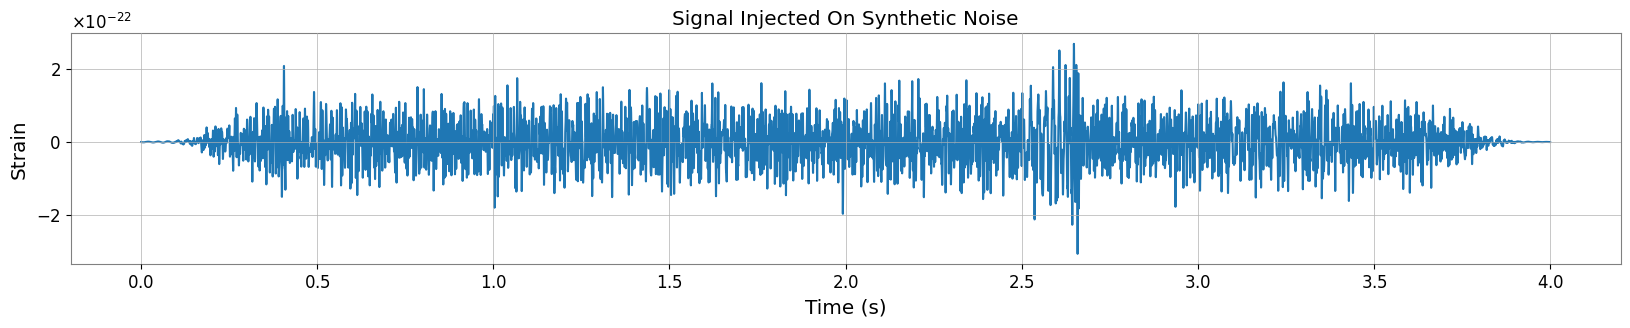

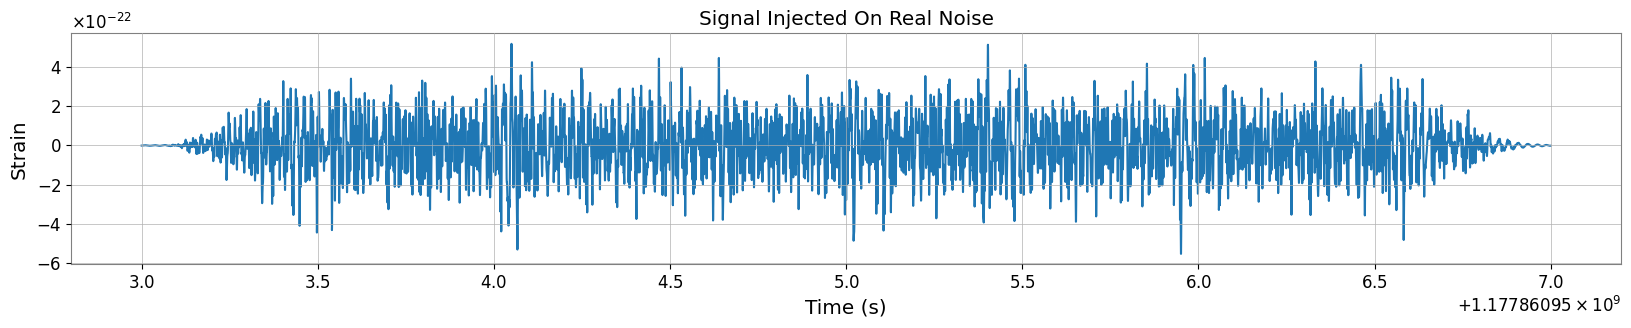

In [2]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries as GTimeSeries

ts = GTimeSeries.read('./combined-dataset/synthetic-noise/synthetic_noise_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

ts = GTimeSeries.read('./combined-dataset/real-noise/real_noise_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

ts = GTimeSeries.read('./combined-dataset/synthetic-signal/synthetic_signal_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected into Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

ts = GTimeSeries.read('./combined-dataset/real-signal/real_signal_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected into Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()


ts = GTimeSeries.read('./combined-dataset/synthetic-signal-injected/synthetic_injected_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected On Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()


ts = GTimeSeries.read('./combined-dataset/real-signal-injected/real_injected_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected On Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

In [17]:
import csv
import pandas as pd

In [18]:
#Merging the injected signal on real noise into single CSV file
path = "./combined-dataset/real-signal-injected/"
files= os.listdir(path)
f = open("./combined-dataset/real-signal-injected.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [04:33<00:00, 16.37it/s]


In [19]:
#Merging the injected signal on synthetic noise into single CSV file
path = "./combined-dataset/synthetic-signal-injected/"
files= os.listdir(path)
f = open("./combined-dataset/synthetic-signal-injected.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [04:08<00:00, 18.05it/s]


In [20]:
#Merging the synthetic noise into single CSV file
path = "./combined-dataset/synthetic-noise/"
files= os.listdir(path)
f = open("./combined-dataset/synthetic-noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [02:38<00:00, 28.22it/s]


In [21]:
#Merging the real noise into single CSV file
path = "./combined-dataset/real-noise/"
files= os.listdir(path)
f = open("./combined-dataset/real-noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [03:14<00:00, 23.03it/s]
